![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Ejercicio opcional de Preprocesamiento 

Recibimos un dataset con información sobre la cancelación de servicios y atributos de clientes que han contratado el servicio de una empresa de telecomunicaciones. En este ejercicio deberás analizar y preparar dicho dataset para entrenar un modelo de Machine Learning que sirva para predecir la tasa de cancelación.

Cada fila del dataset representa un cliente, y cada columna es una atributo de dicho cliente. El dataset contiene la siguiente información:

- **State**: Estado donde vive el cliente.
- **Account length**: Hace cuánto tiempo el cliente contrato el servicio (en días).
- **Area code**: Código de área 
- **International plan**: ¿El cliente ha contratado un plan internacional?
- **Voice mail plan**: ¿El cliente ha contratado un plan de buzón de voz? 
- **Number vmail messages**: Número de mensajes de voz que ha recibido 
- **Total day minutes**: Minutos gastados en llamadas nacionales
- **Total day calls**: Número de llamadas nacionales realizadas 
- **Total day charge**: Cargos nacionales
- **Total intl minutes**: Minutos gastados en llamadas internacionales
- **Total intl calls**: Número de llamadas internacionales 
- **Total intl charge**: Cargos internacionales 
- **Customer service calls**: Llamadas al servicio de cliente 
- **Client type**: Tipo de cliente (frequent caller, moderate caller, infrequent caller)
- **Churn**: ¿El usuario canceló el servicio?

## Importar librerias

In [1]:
import sklearn
import nltk
import pandas as pd
import numpy as np

## Leer datos y realizar revisiones generales

In [2]:
df = pd.read_csv('churn_telco.csv')

In [3]:
df.head().T

,0,1,2,3,4
State,LA,IN,NY,SC,HI
Account length,117,65,161,111,49
Area code,408,415,415,415,510
International plan,No,No,No,No,No
Voice mail plan,No,No,No,No,No
Number vmail messages,0,0,0,0,0
Total day minutes,184.5,129.1,332.9,110.4,119.3
Total day calls,97,137,67,103,117
Total day charge,31.37,21.95,56.59,18.77,20.28
Total intl minutes,8.7,12.7,5.4,7.7,11.1


In [4]:
# Quitamos todos los espacios de los nombres de las columnas y lo ponemos en minúsculas
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [5]:
# Revisamos las columnas del DF
df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'client_type', 'churn'],
      dtype='object')

In [6]:
# Vemos la forma del DF
df.shape

(667, 15)

## ¿Hay variables con valores sin sentido? Si fuese así, corrígelos 

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,667,51,AZ,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_length,667.0,NaN,NaN,NaN,102.841079,40.81948,1.0,76.0,102.0,128.0,232.0
area_code,667.0,NaN,NaN,NaN,436.157421,41.783305,408.0,408.0,415.0,415.0,510.0
international_plan,667,2,No,614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voice_mail_plan,667,2,No,478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_vmail_messages,667.0,NaN,NaN,NaN,8.407796,13.99448,0.0,0.0,0.0,20.0,51.0
total_day_minutes,657.0,NaN,NaN,NaN,181.028463,55.000102,25.9,146.4,178.4,220.7,334.3
total_day_calls,667.0,NaN,NaN,NaN,100.937031,20.39679,30.0,87.5,101.0,115.0,165.0
total_day_charge,657.0,NaN,NaN,NaN,30.775419,9.350029,4.4,24.89,30.33,37.52,56.83
total_intl_minutes,667.0,NaN,NaN,NaN,10.238381,2.80785,0.0,8.6,10.5,12.05,18.3


In [8]:
# Observamos que hay valores negativos en la columna total_intl_calls
# Cambiamos los valores dividiendo los minutos por la media de minutos/llamada de las demás filas) 
df.loc[
    df.total_intl_calls < 0,
    'total_intl_calls'
] = (
    np.round(
        df[df.total_intl_calls < 0]['total_intl_minutes']
        / (df[df.total_intl_calls >= 0]['total_intl_minutes'].sum() / df[df.total_intl_calls >= 0]['total_intl_calls'].sum())
    )
).astype('int64')

In [9]:
# Comprobamos los valores para total_intl_minutes == 0, se espera que total_intl_calls y total_intl_charge == 0
df[df.total_intl_minutes == 0][['total_intl_minutes', 'total_intl_calls', 'total_intl_charge']]

,total_intl_minutes,total_intl_calls,total_intl_charge
324,0.0,0,0.0
654,0.0,0,0.0
659,0.0,0,0.0


## ¿Hay variables con valores vacíos? Si fuese así, rellénalos

In [10]:
# Buscamos valores nulos en todas las variables
df.isna().sum()

state                      0
account_length             0
area_code                  0
international_plan         0
voice_mail_plan            0
number_vmail_messages      0
total_day_minutes         10
total_day_calls            0
total_day_charge          10
total_intl_minutes         0
total_intl_calls           0
total_intl_charge          0
customer_service_calls     0
client_type                0
churn                      0
dtype: int64

In [11]:
# Rellenamos total_day_minutes con media de minutos por llamada * total_day_calls
df.loc[
    df.total_day_minutes.isnull(),
    'total_day_minutes'
] = np.round(
        df[df.total_day_minutes.isna()]['total_day_calls']
        * df[df.total_day_minutes.notnull()]['total_day_minutes'].sum()
        / df[df.total_day_minutes.notnull()]['total_day_calls'].sum(),
        1)


In [12]:
# Calculamos el precio total por minuto de los total_day_charge que no tienen nulos
# y lo multiplicamos por los minutos calculados en el paso anterior
df.loc[
    df.total_day_charge.isnull(),
    'total_day_charge'
] = np.round(
    df[df.total_day_charge.isnull()]['total_day_minutes']
    * df[df.total_day_charge.notnull()]['total_day_charge'].sum()
    / df[df.total_day_charge.notnull()]['total_day_minutes'].sum(),
    2)

## ¿Qué porcentaje de los clientes en el dataset han cancelado el servicio?

In [13]:
df[df.churn == True].churn.count() / df.churn.count() * 100

14.24287856071964

## ¿Qué variables están más correladas con `Churn`?

In [14]:
# Buscamos las variables más correladas con Churn: total_day_minutes (y por lo tanto total_day_charge) y customer_service_calls
df.corrwith(df.churn)

account_length            0.012315
area_code                 0.027129
number_vmail_messages    -0.102381
total_day_minutes         0.229097
total_day_calls           0.019360
total_day_charge          0.229094
total_intl_minutes       -0.003740
total_intl_calls          0.015234
total_intl_charge        -0.003681
customer_service_calls    0.233259
churn                     1.000000
dtype: float64

## Haz un boxplot en el que muestres la distribución de `Total day minutes` de acuerdo a si un cliente ha cancelado el servicio o no 

<AxesSubplot:title={'center':'total_day_minutes'}, xlabel='[churn]'>

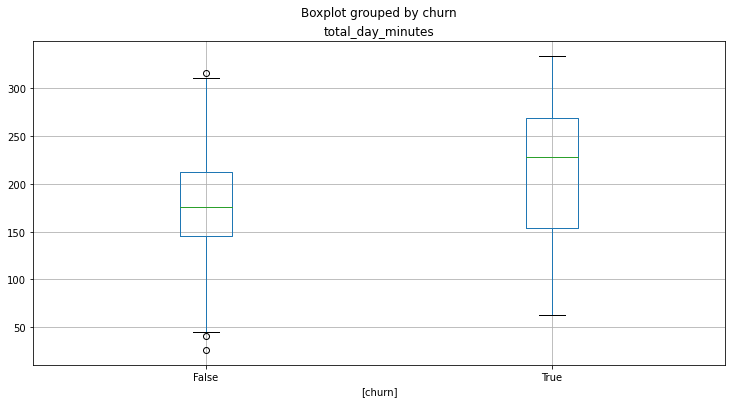

In [15]:
# Los clientes que se dieron de baja tienen más minutos de llamadas
df[["total_day_minutes", "churn"]].boxplot(by="churn", figsize=(12, 6))

<AxesSubplot:title={'center':'customer_service_calls'}, xlabel='[churn]'>

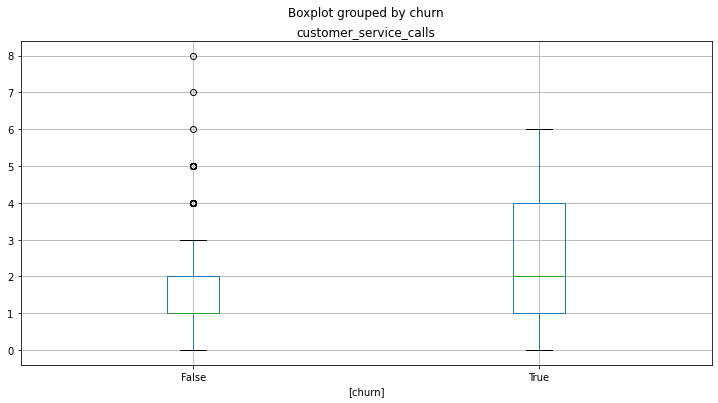

In [16]:
# También nos interesa un boxplot de la distribución de customer_service_calls
df[["customer_service_calls", "churn"]].boxplot(by="churn", figsize=(12, 6))

## Divide el dataset en train y test, haciendo un split 90/10

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, stratify=df.churn, random_state=42)

## Crea una columna nueva en los dataset de train y test donde apliques `OrdinalEncoder` a la columna `State` (ignorar `SettingWithCopyWarning`)

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [19]:
# Copiamos los df para hacer las modificaciones con OrdinalEncoder
df_train_enc = df_train.copy()
df_test_enc = df_test.copy()

In [20]:

enc.fit(df_train_enc[['state']])

df_train_enc['state_enc'] = enc.transform(df_train_enc[['state']])
df_test_enc['state_enc'] = enc.transform(df_test_enc[['state']])

## Aplicar `OneHotEncoder` a la columna `Client type` (no hace falta guardar el resultado como columnas en el dataset)

In [21]:
from sklearn.preprocessing import OneHotEncoder
enc2 = OneHotEncoder()

In [22]:
# Copiamos los df para hacer modificaciones con OneHotEncoder
df_train_enc2 = df_train.copy()
df_test_enc2 = df_test.copy()

In [23]:
enc2.fit(df_train_enc2[['client_type']])

enc2.transform(df_train_enc2[['client_type']])
enc2.transform(df_test_enc2[['client_type']])

<67x3 sparse matrix of type '<class 'numpy.float64'>'
	with 67 stored elements in Compressed Sparse Row format>